# Jupyter Demonstration Notebook

Author: Marcus D. Bloice <https://github.com/mdbloice>

In this notebook we will explore the ISIC dataset, do some cleaning of the data, preview some of the images, and prepare them to be used to train a neural network. 

This should be a good head start for beginning the assignment. 

Also we will briefly describe how to used a pre-trained network, and show the first steps towards using a pre-trained network for your assignment. 

First we will perform some imports:

In [1]:
import numpy as np
import pandas as pd

# Suppress warnings: scipy warns that stats.itemfreq is 
# deprecated so we will ignore these warnings in this notebook
import warnings
warnings.filterwarnings("ignore")

# Useful collection of statistics functions
from scipy import stats

# MatPlotLib is the de facto standard plotting library for Python
import matplotlib.pyplot as plt

# Python Image Library
from PIL import Image

# For scanning directories for files glob is useful as is os
import glob
import os

# SciKit Learn has many utility functions that are useful
from sklearn.model_selection import train_test_split

# For our deep learning we will use Keras, which is now included in TensorFlow
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Tell MatPlotLib that it should plot images inline on the notebook
%matplotlib inline

## Loading in the Data and Data Exploration

First we use `glob` to read all the `*.jpg` images into a list:

In [2]:
image_file_list = glob.glob("/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/*.jpg")

Check its length to see how many images we found (it should be 10,015):

In [3]:
len(image_file_list)

10015

We can preview the first ten:

In [4]:
image_file_list[:10]

['/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0030858.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0030680.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0033389.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0032097.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0032929.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0026784.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0028971.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0026948.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0026790.jpg',
 '/Users/marcus/Downloads/ISIC2018_Task3_Training_Input/ISIC_0028965.jpg']

We will use these paths later to load all the images into memory.

We can take a look at an image using some random index:

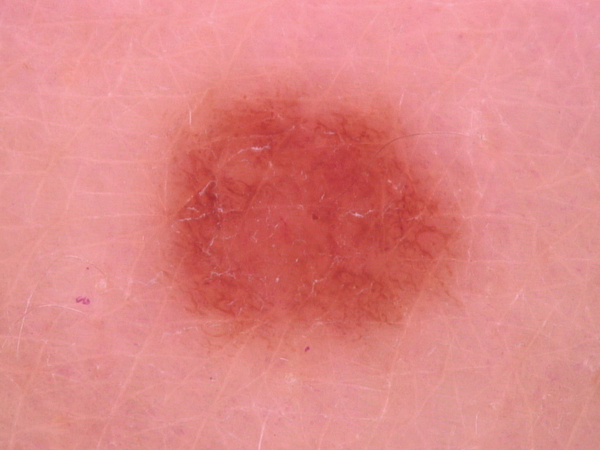

In [5]:
Image.open(image_file_list[55])

Now that we have a list of image paths, we can read the CSV which contains the diagnosis for each image in the dataset.

We can use Pandas `read_csv()` to quickly read the file into memory:

In [6]:
csv_file_location = "/Users/marcus/Downloads/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"
csv_contents = pd.read_csv(csv_file_location)

The `head()` and `tail()` functions are useful for previewing large datasets:

In [7]:
csv_contents.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


We can also check the length of the dataset which should match the number of images we have:

In [8]:
len(csv_contents)

10015

You will notice the values in the dataset are floats, we will change these to integers (PS there are better ways of doing this column by column, but it will do for now):

In [9]:
csv_contents.MEL = csv_contents.MEL.astype(int)
csv_contents.NV = csv_contents.NV.astype(int)
csv_contents.BCC = csv_contents.BCC.astype(int)
csv_contents.AKIEC = csv_contents.AKIEC.astype(int)
csv_contents.BKL = csv_contents.BKL.astype(int)
csv_contents.DF = csv_contents.DF.astype(int)
csv_contents.VASC = csv_contents.VASC.astype(int)

In [10]:
csv_contents.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0,1,0,0,0,0,0
1,ISIC_0024307,0,1,0,0,0,0,0
2,ISIC_0024308,0,1,0,0,0,0,0
3,ISIC_0024309,0,1,0,0,0,0,0
4,ISIC_0024310,1,0,0,0,0,0,0


Let's get a count of all the values and then plot these. The `value_counts()` function returns counts for each item, in our case the number of 0s (negative diagnosis) and number of 1s (positive diagnosis): 

In [11]:
csv_contents.MEL.value_counts(sort=False)

0    8902
1    1113
Name: MEL, dtype: int64

So there are 1113 malignant melanoma in the dataset.

Let's do that for all the columns to get an idea of how our data looks. We can then plot a distribution of the data:

In [12]:
mel_counts = csv_contents.MEL.value_counts(sort=False)[1]
nv_counts = csv_contents.NV.value_counts(sort=False)[1]
bcc_counts = csv_contents.BCC.value_counts(sort=False)[1]
akiec_counts = csv_contents.AKIEC.value_counts(sort=False)[1]
bkl_counts = csv_contents.BKL.value_counts(sort=False)[1]
df_counts = csv_contents.DF.value_counts(sort=False)[1]
vasc_counts = csv_contents.VASC.value_counts(sort=False)[1]

counts = [mel_counts, nv_counts, bcc_counts, akiec_counts, bkl_counts, df_counts, vasc_counts]

counts_df = pd.DataFrame(counts, columns=["Count"], index=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
counts_df

,Count
MEL,1113
NV,6705
BCC,514
AKIEC,327
BKL,1099
DF,115
VASC,142


Sorting them descending order makes it easier to see how the data looks:

In [13]:
counts_df.sort_values(by="Count", ascending=False)

,Count
NV,6705
MEL,1113
BKL,1099
BCC,514
AKIEC,327
VASC,142
DF,115


It is important to sometimes perform sanity tests, for example the total number of diagnosis should equal the total number of images, as every image has 1 diagnosis:

In [14]:
print("The number of diagnoses is %s, and the number of images is %s" 
      % (np.cumsum(counts)[-1], len(image_file_list)))

The number of diagnoses is 10015, and the number of images is 10015


If these two number would not match, we have done something wrong.

Pandas allows us to quickly plot data, and this shows us the distribution of the diagnoses very clearly:

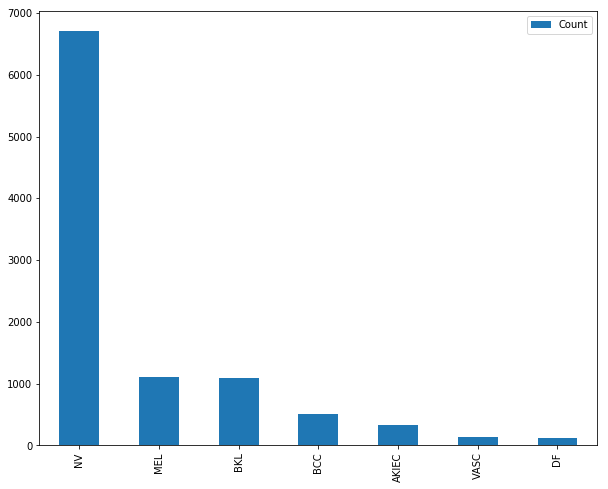

In [15]:
counts_df.sort_values(by="Count", ascending=False).plot(kind="bar", figsize=(10,8));

As you can see, we have quite an imbalanced dataset, we have many more NV lesions as MEL lesions. We also have nearly the same number of BKL lesions as MEL lesions. 

We could also plot a pie chart:

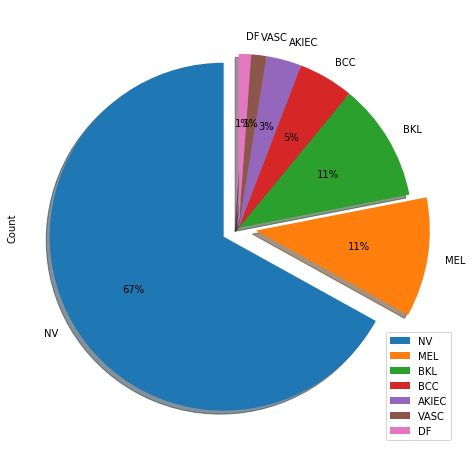

In [16]:
counts_df.sort_values(by="Count", ascending=False).plot.pie(subplots=True, 
                                                            figsize=(8,8), 
                                                            autopct='%1.0f%%', 
                                                            explode=[0.1,0.1,0,0,0,0,0],
                                                            shadow=True,
                                                            startangle=90);

When training your neural network, you will need to account for this imbalance. You may want to use all the MEL images but sample an equal amount of NV images from the ensire set so that they are balanced. 

Also, with imbalanced datasets, it is crucial that you are very careful interpreting the "accuracy" metric of the trained model! We will discuss why a little later.

## Creating the Dataset for the ML Task

Now we have a list of the images and a CSV containing the ground truth data (the labels). 

We want to construct a dataset consisting of the image data, stored in a variable `X` and each image's label, stored in a variable `y`. 

It is convention to use uppercase `X` for matrix data (in this case our images) and lower case `y` for label vectors, in this case each image's label which is either 0 for benign or 1 for malignant. 

In this step we read every image using PIL, and then convert these images into their raw pixel values and stored them as arrays.

First we search the CSV file for each image and only select those where *either* **MEL** or **NV** are 1 and ignore the rest:

In [17]:
X = []  # Will contain our images as raw pixel value array data
y = []  # Will contain our labels, either 0 for benign or 1 for malignant
count = 0

for image in image_file_list:
    # Keep a count of the processed images to display a progress
    count += 1
    
    # Find the label for that image and add to y
    file_name = os.path.basename(image)
    file_name = str.split(file_name, ".jpg")[0]
    row = csv_contents.loc[csv_contents['image'] == file_name]
    
    # If we encounter a MEL or an NV then we add it to X and y
    if np.array(row.MEL)[0] == 1:
        im = Image.open(image)
        im_array = np.asarray(im)
        X.append(im_array)
        y.append(1)
    elif np.array(row.NV)[0] == 1:
        im = Image.open(image)
        im_array = np.asarray(im)
        X.append(im_array)
        y.append(0)
    
    # Print the progress...
    if count % 1000 == 0:
        print("Processed %s images..." % count)

Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...


Let's have a look at our data and ensure it looks as we expect:

In [18]:
# np.shape(X)
len(X)

7818

This should match the length of the labels:

In [19]:
len(y)

7818

Also the length of `y` should be the same as the number NV and MEL images combined, so let's confirm that:

In [20]:
counts_df

,Count
MEL,1113
NV,6705
BCC,514
AKIEC,327
BKL,1099
DF,115
VASC,142


In [21]:
counts_df.loc['MEL'] + counts_df.loc['NV']

Count    7818
dtype: int64

That should match up.

We now have our image data stored in `X` and our label data stored in `y`. 

Let's have a look at a random image (and its label) to make sure it was converted OK:

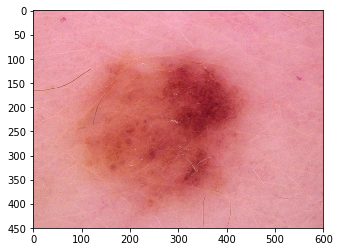

In [22]:
plt.imshow(X[55]);

In [23]:
y[55]

0

Remember that 0 means benign nevus, while 1 means malignant melanoma.

**Important Note** the images we loaded in to `X` are not preprocessed in any way! For any machine learning task, there is a certain amount of preprocessing that must be performed, for example to normalise the pixel values and to convert the images from 0-255 integer arrays to floats between 0-1. We will see this later in the demo of the pre-trained network.

### Creating a train and test split

In order to properly test your network you must train it using a training set, and test it on a held back dataset, called a test set. There are utility functions available in SciKit Learn (Python's machine learning library) that can do this for you:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print("Training set size: %s\nTest set size: %s" % (len(X_train), len(X_test)))

Training set size: 5863
Test set size: 1955


However, if you observe once again the distribution of the labels, you will see they are skewed, for example the training set looks as follows:

In [25]:
train_counts = stats.itemfreq(y_train)
train_counts = pd.DataFrame(train_counts, columns=['Class', 'Count'], index=['NV','MEL'])
train_counts

,Class,Count
NV,0,5025
MEL,1,838


We can also plot this easily, as we did before:

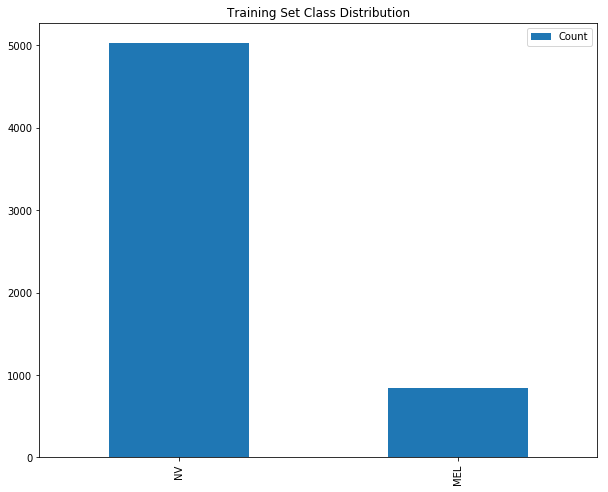

In [26]:
train_counts = train_counts.drop("Class", axis=1)
train_counts.plot(kind="bar", figsize=(10,8), title="Training Set Class Distribution");

The same is true of the test set:

In [27]:
test_counts = stats.itemfreq(y_test)
test_counts = pd.DataFrame(test_counts, columns=['Class', 'Count'], index=['NV','MEL'])
test_counts

,Class,Count
NV,0,1680
MEL,1,275


Which we can likewise plot:

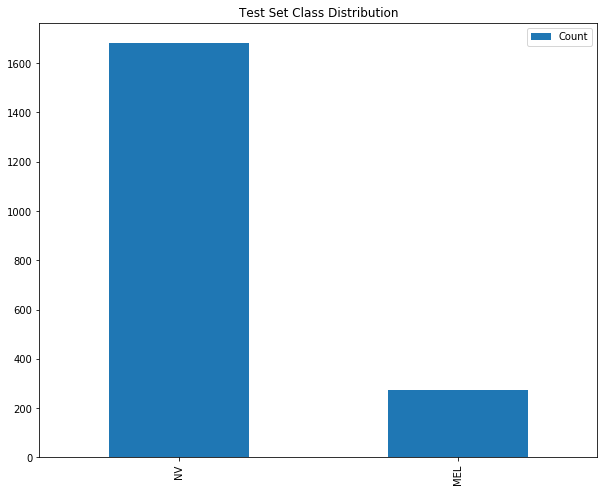

In [28]:
test_counts = test_counts.drop("Class", axis=1)
test_counts.plot(kind="bar", figsize=(10,8), title="Test Set Class Distribution");

This is a problem for several reasons. One problem is that you may inerpret the accuracy of the network incorrectly. 

Accuracy is defined as: 

$$
\text{Accuracy} = \frac{\mathit{TP} + \mathit{TN}}{P + N}
$$

Where $\mathit{TP}$ are the number of true positives, $\mathit{TN}$ is the number true negatives, and $P$ is the number of positive samples and $N$ is the number of negative samples in the dataset.

Or more simply:

$$
\text{Accuracy} = \frac{\text{Correct predictions}}{\text{Total predictions made}}
$$

If the network predicted that every image in the test set was benign, then the total number of correct predictions would be equal to the number of benign lesions in the data set:

$$
\text{Accuracy} = \frac{\text{Correct predictions}}{\text{Total predictions made}} = \frac{1680}{1955} = 0.859
$$

which gives:

$$
\text{Accuracy} = 0.859
$$

That is an accuracy of 86% merely for guessing the same class for any input!

### Balancing your Data Set

For your assignment you will need to properly balance your dataset, or think of some other method to compensate for the class imbalance. 

When evaluating your results using a test set that is imbalanced, use other metrics such as SciKit Learn's balanced accuracy score `sklearn.metrics.balanced_accuracy_score()`, the ROC-AUC metric, or by closely examining the confusion matrix (see `sklearn.metrics.confusion_matrix()`).

Balancing the dataset can be done by simply choosing all the melanoma images and sampling the same number of nevi images from the total.

# Transfer Learning

## Using a Pre-trained Network

Using the deep learning library Keras we can use pretrained networks that were trained for long amounts of time on the ImageNet dataset. In this example we will download the VGG16 network which was the winner of the ImageNet challenge several years ago. Using pre-trained networks, and fine tuning them with your data is an example of "transfer learning". 

First we shall load the pretrained network:

In [29]:
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


This will download the pre-trained network if you have not already done so in the past. It is approximately 600MB in size. 

Now we can take a look at the structure of the network:

In [30]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The VGG network has

- 16 layers
- Its input layer expects images sized 224x224 pixels
- The output layer contains 1000 neurons (ImageNet is a 1,000 class dataset)
- The `summary()` function also describes the number of trainable and non-trainable parameters 

### Classifying an Image with the Pre-trained Network

Let's grab an image from the internet and classify it with the pre-trained network. First we read in and preview an image that we downloaded from the internet:

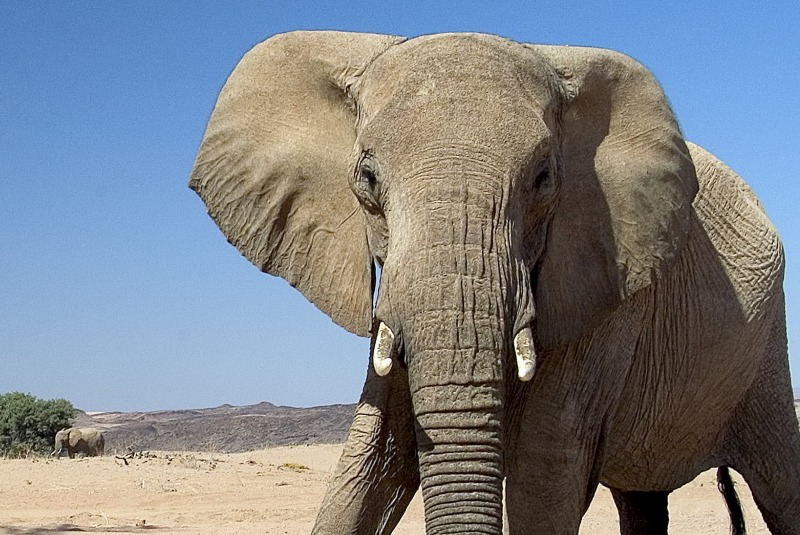

In [31]:
# Image from https://seethewild.org/wp-content/uploads/2016/04/Elephant-Photo-Credit-Ultimate-Safaris-gallery.jpg
img_path = './elephant.jpg'
Image.open(img_path)

In order to pass the image into the network, we need to resize it to 224x224 (as that is what the network expects and was trained for) and also pre-process the image:

In [32]:
img = preprocessing.image.load_img(img_path, target_size=(224, 224))
x = preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

For your assignment, you will need to insure you pre-process the lesion data in exactly this way for it to work correctly. 

Let's have a look at the image after preprocessing:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


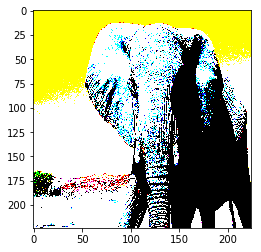

In [33]:
plt.imshow(x.reshape((224,224,3)));

Let's now use the pre-trained network to predict what the image is. 

Remember that networks pre-trained on ImageNet have 1,000 classes. Some examples are:

1. 'goldfish, Carassius auratus',
2. 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
3. 'tiger shark, Galeocerdo cuvieri',
4. 'hammerhead, hammerhead shark',
5. 'electric ray, crampfish, numbfish, torpedo',
6. 'stingray',
15. 'robin, American robin, Turdus migratorius',
16. 'bulbul',
17. 'jay',
18. 'magpie',
19. 'chickadee',
20. 'water ouzel, dipper',
21. 'kite',
64. 'green mamba',
65. 'sea snake',
66. 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
67. 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
68. 'sidewinder, horned rattlesnake, Crotalus cerastes',
69. 'trilobite',
70. 'harvestman, daddy longlegs, Phalangium opilio',
71. 'scorpion',
72. 'black and gold garden spider, Argiope aurantia',
73. 'barn spider, Araneus cavaticus',
74. 'garden spider, Aranea diademata',
75. 'black widow, Latrodectus mactans',
76. 'tarantula',
437. 'beacon, lighthouse, beacon light, pharos',
438. 'beaker',
440. 'beer bottle',
441. 'beer glass',
444. 'bicycle-built-for-two, tandem bicycle, tandem',
446. 'binder, ring-binder',
447. 'binoculars, field glasses, opera glasses',
448. 'birdhouse',
449. 'boathouse',
450. 'bobsled, bobsleigh, bob',
671. 'mountain bike, all-terrain bike, off-roader',
672. 'mountain tent',
673. 'mouse, computer mouse',
674. 'mousetrap',
675. 'moving van',
678. 'neck brace',
679. 'necklace',
681. 'notebook, notebook computer',
682. 'obelisk',
1000. ...

When we make a prediction with the network, we will get a probability distribution across 1,000 classes: 

In [34]:
print(vgg16.predict(x))

[[3.71664748e-11 2.04877754e-14 7.10554283e-13 1.16393776e-12
  2.97684880e-12 1.58085160e-11 1.54411553e-12 1.58902873e-11
  7.04046413e-13 3.12796935e-08 2.90274613e-13 1.58579665e-13
  6.63906864e-13 1.91957534e-13 2.11076789e-13 6.88103274e-13
  9.03554954e-13 8.61372714e-13 4.03913882e-12 1.38822905e-12
  4.91527066e-13 2.81905027e-10 1.49170204e-10 1.09702558e-09
  8.55466253e-11 2.80155565e-13 4.28196134e-13 8.03081831e-14
  7.45545186e-14 1.88873765e-13 4.59647674e-13 2.06448506e-13
  1.37690824e-12 1.36793632e-10 5.71220682e-10 2.71833805e-11
  7.28007724e-11 5.35431508e-13 1.07956769e-11 3.08991055e-09
  9.03776012e-12 1.02976525e-11 2.50076237e-10 2.35570372e-08
  7.39248940e-12 6.41743186e-11 6.86885444e-12 3.26834726e-10
  8.27536084e-08 5.66713787e-10 5.22309036e-11 1.65173708e-06
  1.77431930e-12 5.16466644e-13 6.48392928e-12 1.67651483e-12
  2.66903931e-13 4.95394416e-13 2.86343727e-11 7.37347574e-13
  3.31995239e-12 7.51652733e-12 4.65040645e-11 1.19777979e-10
  6.1094

Luckily, we need can decode this into something we can read and we will also format the probibilties to percentages, we can use the Keras `decode_predictions()` function for this:

In [35]:
res = decode_predictions(vgg16.predict(x), top=3)[0]
print("-----\n1:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[0][1], res[0][2]*100))
print("-----\n2:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[1][1], res[1][2]*100))
print("-----\n3:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[2][1], res[2][2]*100))

-----
1:
Class: African_elephant
Probability: 85.29%
-----

-----
2:
Class: tusker
Probability: 9.48%
-----

-----
3:
Class: Indian_elephant
Probability: 5.19%
-----



Summing the prediction probabilities for all 1000 classes will result in 1 (100%).

## Fine Tuning a Pre-Trained Network

As part of your assignment, you need to fine tune a neural network. 

This means you use a pre-trained network, such as the one above, but you remove the topmost layers (for example all the fully connected layers) and add new randomly initialised layers that you then train with your own data (fine tuning).

When you are fine-tuning, it is important that you freeze the lower layers of the network, so that when you training it with your data, that you only train the top most layers. The lower layers contain features and filters that you wish to keep.

Also, the final layer needs to match the size of new classification task, in the case of this project that is 2.

1. Download a pre-trained network
2. Remove the top most layers (the final layers of the network)
3. Freeze the remaining layers so that they are not updated during training
4. Add new (randomly initialised) layers to the network
5. Train the network on your data (which will only update the new layers) 

See <https://keras.io/applications/> for further information. 

### Task

Your task for this assignment is to use a pre-trained network, update it with the ISIC image dataset, and classify a test set of images that you should randomly select. 

Experiment with the various pre-trained networks that Keras provides. 

Several examples can be found here: 

<https://keras.io/applications/>

In this notebook we used VGG16, but there are many others. It provides a table of how well each network perform at classifying ImageNet:

| Model             | Size   | Top-1 Accuracy | Top-5 Accuracy | Parameters  | Depth |
|-------------------|--------|----------------|----------------|-------------|-------|
| Xception          | 88 MB  | 0.790          | 0.945          | 22,910,480  | 126   |
| VGG16             | 528 MB | 0.713          | 0.901          | 138,357,544 | 23    |
| VGG19             | 549 MB | 0.713          | 0.900          | 143,667,240 | 26    |
| ResNet50          | 98 MB  | 0.749          | 0.921          | 25,636,712  | -     |
| ResNet101         | 171 MB | 0.764          | 0.928          | 44,707,176  | -     |
| ResNet152         | 232 MB | 0.766          | 0.931          | 60,419,944  | -     |
| ResNet50V2        | 98 MB  | 0.760          | 0.930          | 25,613,800  | -     |
| ResNet101V2       | 171 MB | 0.772          | 0.938          | 44,675,560  | -     |
| ResNet152V2       | 232 MB | 0.780          | 0.942          | 60,380,648  | -     |
| ResNeXt50         | 96 MB  | 0.777          | 0.938          | 25,097,128  | -     |
| ResNeXt101        | 170 MB | 0.787          | 0.943          | 44,315,560  | -     |
| InceptionV3       | 92 MB  | 0.779          | 0.937          | 23,851,784  | 159   |
| InceptionResNetV2 | 215 MB | 0.803          | 0.953          | 55,873,736  | 572   |
| MobileNet         | 16 MB  | 0.704          | 0.895          | 4,253,864   | 88    |
| MobileNetV2       | 14 MB  | 0.713          | 0.901          | 3,538,984   | 88    |
| DenseNet121       | 33 MB  | 0.750          | 0.923          | 8,062,504   | 121   |
| DenseNet169       | 57 MB  | 0.762          | 0.932          | 14,307,880  | 169   |
| DenseNet201       | 80 MB  | 0.773          | 0.936          | 20,242,984  | 201   |
| NASNetMobile      | 23 MB  | 0.744          | 0.919          | 5,326,716   | -     |
| NASNetLarge       | 343 MB | 0.825          | 0.960          | 88,949,818  | -     |

Over the years networks have become more sophisticated and can perform as well as networks with much smaller number of parameters. Compare VGG19 to InceptionV3, for example. Lower numbers of parameters also means smaller model sizes, as shown in MB. 

# Resources and Notes

- Get the dataset here: https://goo.gl/DZh6ag 
    - The dataset is from Task 3 of the 2018 ISIC challenge, see:  https://challenge2018.isic-archive.com/ 
- Collection of Keras pre-trained networks, known as Applications: https://keras.io/applications/  
- Free GPU can be used at Google Colab: https://colab.research.google.com 
- For help use the course's Gitter channel: https://gitter.im/MLHI2019/community
- If you need to contact directly, my address is marcus.bloice@medunigraz.at 
- To submit your assignment, send me your work as a Jupyter notebook! 